# Teched 2022 - DA180 Session - Exercise 6

## Import the requied python packages

In [4]:
import hana_ml
print(hana_ml.__version__)
from hana_ml import dataframe
from hana_ml.dataframe import create_dataframe_from_pandas, create_dataframe_from_shapefile
from hana_ml.algorithms.pal.tsa.additive_model_forecast import AdditiveModelForecast
from hana_ml.algorithms.pal import metrics
from hdbcli import dbapi
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon




2.14.22092300


## Connect to hana database

In [ ]:
host = '[YourHostName]'
port = 443
user = '[YourUser]'
passwd = '[YourUserPassword]'

In [3]:
#conn = dataframe.ConnectionContext(url, port, user, pwd)
conn= dataframe.ConnectionContext(address=host, port=port, user=user, password=passwd,
                               encrypt='true' ,sslValidateCertificate='false')

In [6]:
#conn = dataframe.ConnectionContext( address="<machine>", port=<SQL-port>,  user="<HANA-user>", password="<password>")
hc_url = '859c0f95-60f9-4540-aa81-581a8e452c6f.hna1.canary-eu10.hanacloud.ondemand.com'
conn = dataframe.ConnectionContext( address=hc_url, port=443, user="TECHED_USER_9##", password='###' )
conn.hana_version()

'4.00.000.00.1663064250 (fa/CE2022.30)'

# Exercise 6 - Build a ML classification model on multi-model data

# EX6.1 Prepare and explore fuel station classification data

?? Clone data from https://github.com/SAP-samples/teched2022-DA180/tree/main/data/fuelprice

In [8]:
# Creating a station price class type label "STATION_CLASS", derived from daily average e5-price
stations_class=conn.sql(
"""
SELECT "station_uuid", E5_AVG, BINNING(VALUE => E5_AVG, BIN_COUNT => 10) OVER () AS STATION_CLASS 
  FROM ( SELECT  "station_uuid",  avg("e5") AS E5_AVG 
         FROM (  SELECT "date", DAY, HOUR, "station_uuid", "e5" 
                 FROM  RAW_DATA.GAS_PRICES_ANALYSIS 
                 WHERE  "e5" > 1.3 AND "e5" < 2.8)
         GROUP BY "station_uuid" 
         HAVING COUNT("e5")>20);
"""
)
stations_class.collect()

,station_uuid,E5_AVG,STATION_CLASS
0,00006210-0037-4444-8888-acdc00006210,1.948780,4
1,00016899-3247-4444-8888-acdc00000007,1.992414,5
2,00041414-208c-4444-8888-acdc00000414,2.016500,5
3,00041450-0002-4444-8888-acdc00000002,1.931636,4
4,00047369-0001-4444-8888-acdc00000001,1.962834,4
...,...,...,...
14823,c8e031a6-7aeb-45dc-b0e1-a3afd3bea3d0,1.975564,4
14824,c8e538a5-f4af-49e8-bef6-a173c55c3e5f,1.986790,5
14825,c8e68ec5-8eac-11e9-83b5-005056a2a083,1.963040,4
14826,c8edb8a3-5b17-42d6-89f1-cfff8233311a,1.988955,5


In [7]:
# Create station masterdata HANA dataframe: station_master
stations_hdf = conn.table("GAS_STATIONS")

#print("There are", stations_hdf.count(), "service stations in Germany")
#display(stations_hdf.head(3).collect())

station_master=stations_hdf.select('uuid', 'brand', 'post_code', ('substr("post_code",1,2)', 'post_code2'), 'city')
display(station_master.head(3).collect())

,uuid,brand,post_code,post_code2,city
0,064554c1-d960-444e-bc1b-0a0449711e44,Shell,10585,10,BERLIN
1,0ba0e8ac-ae93-4a29-837c-165bfa0fac2f,ARAL,74199,74,Untergruppenbach
2,2020d9be-d9db-456f-9bd1-c72f3ad5d279,ARAL,12103,12,Berlin


In [17]:
# Derive some station-related e5-price indicators in a HANA dataframe: stations_price_indicators
stations_price_indicators=conn.sql(
"""
SELECT "station_uuid", 
        /* Daily E5 change related indicators */
        SUM(CAST("N_E5C_D" as DOUBLE)) AS SUM_E5C, MIN(CAST("N_E5C_D" as DOUBLE)) AS MIN_E5C, MAX(CAST("N_E5C_D" as DOUBLE)) AS MAX_E5C, AVG("N_E5C_D") AS AVG_E5C, 
        STDDEV("N_E5C_D") AS STDEV_E5C, MAX(CAST("N_E5C_D" as DOUBLE))-MIN(CAST("N_E5C_D" as DOUBLE)) AS RANGE_E5C,
        /* Daily E5 price related indicators */
        AVG("VAR_E5_D") AS AVG_E5_VAR,  AVG("STDDEV_E5_D") AS AVG_E5_STD,  AVG("MIN_E5_D") AS AVG_E5_MIN,  
        AVG("MAX_E5_D") AS AVG_E5_MAX, SUM("RANGE_E5_D") AS SUM_E5_RANGE,  AVG("RANGE_E5_D") AS AVG_E5_RANGE 
    FROM (
          SELECT "station_uuid", DAY,  
                /* Daily price analysis indicators */
                count("e5change") AS N_E5C_D, VAR("e5") AS VAR_E5_D,  STDDEV("e5") AS STDDEV_E5_D,  MIN("e5") AS MIN_E5_D, 
                MAX("e5") AS MAX_E5_D, AVG("e5") AS AVG_E5_D, MAX("e5")-MIN("e5") AS RANGE_E5_D
          FROM (
                  SELECT "date", DAY, HOUR, "station_uuid", "e5", "e5change" 
                  FROM  RAW_DATA.GAS_PRICES_ANALYSIS 
                  WHERE  "e5" > 1.3 AND "e5" < 2.8)
          GROUP BY "station_uuid", DAY)
    GROUP BY "station_uuid";
"""
)
stations_price_indicators.head(3).collect()

,station_uuid,SUM_E5C,MIN_E5C,MAX_E5C,AVG_E5C,STDEV_E5C,RANGE_E5C,AVG_E5_VAR,AVG_E5_STD,AVG_E5_MIN,AVG_E5_MAX,SUM_E5_RANGE,AVG_E5_RANGE
0,00006210-0037-4444-8888-acdc00006210,4455.0,10.0,38.0,25.901162,5.267865,28.0,0.000894,0.028872,1.897663,2.007081,18.82,0.109419
1,00016899-3247-4444-8888-acdc00000007,905.0,1.0,14.0,6.033333,2.573527,13.0,0.001109,0.029554,1.943933,2.018733,11.22,0.074800
2,00041414-208c-4444-8888-acdc00000414,72.0,1.0,4.0,1.220338,0.55918,3.0,0.000255,0.003244,2.009000,2.014085,0.30,0.005085


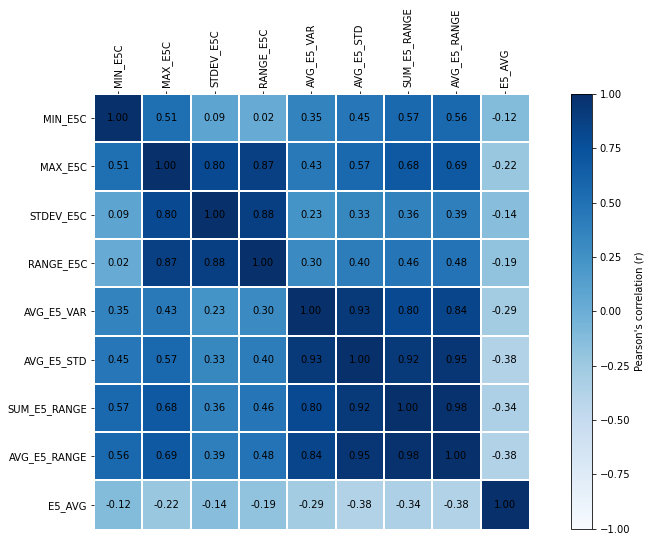

In [15]:
# Evaluate correlation of indicators with AVG(e5) and thus target class

# Join indicator columns with AVG(e5)
stations_num=stations_price_indicators.set_index("station_uuid").join(
             stations_class.drop('STATION_CLASS').set_index("station_uuid"))
#display(stations_num.head(5).collect())

# Avoid usage of intercorrelated indicators, e.g. correlate numerical columns
import matplotlib.pyplot as plt
from hana_ml.visualizers.eda import EDAVisualizer
f = plt.figure(figsize=(15, 8))
ax1 = f.add_subplot(111)
eda = EDAVisualizer(ax1)
ax1, corr = eda.correlation_plot(data=stations_num.drop('station_uuid'), cmap="Blues")
plt.show()

In [18]:
# Drop high correlated indicator columns
stations_price_indicators=stations_price_indicators.drop('AVG_E5_MIN').drop('AVG_E5_MAX').drop('SUM_E5C').drop('AVG_E5C')
stations_price_indicators=stations_price_indicators.drop('AVG_E5_STD').drop('SUM_E5_RANGE').drop('AVG_E5_RANGE')
stations_price_indicators.head(3).collect()

,station_uuid,MIN_E5C,MAX_E5C,STDEV_E5C,RANGE_E5C,AVG_E5_VAR
0,00006210-0037-4444-8888-acdc00006210,10.0,38.0,5.267865,28.0,0.000894
1,00016899-3247-4444-8888-acdc00000007,1.0,14.0,2.573527,13.0,0.001109
2,00041414-208c-4444-8888-acdc00000414,1.0,4.0,0.55918,3.0,0.000255


# Exercise 6.2 Enrich fuel station classification data with spatial attributes

distance to next station  
number of stations in cluster  
distance to autobahn, bundestraße, ... - aus OSM ... oder OSMNX (zu fein, da graph und kein linestring für autobahn)

In [20]:
# Create a station spatial hierarchy HANA dataframe
stations_spatialhierarchy = stations_hdf.select('uuid', 'longitude','latitude','longitude_latitude_GEO')

# Derive spatial hierarchy features from station point location
stations_spatialhierarchy =stations_spatialhierarchy.generate_feature(targets='longitude_latitude_GEO', 
                                                          trans_func='GEOHASH_HIERARCHY', trans_param=range(3,8))

# Rename columns
stations_spatialhierarchy=stations_spatialhierarchy.rename_columns({'GEOHASH_HIERARCHY(longitude_latitude_GEO,3)': 'GEO_H3', 
                                                                    'GEOHASH_HIERARCHY(longitude_latitude_GEO,4)': 'GEO_H4', 
                                                                    'GEOHASH_HIERARCHY(longitude_latitude_GEO,5)': 'GEO_H5',
                                                                    'GEOHASH_HIERARCHY(longitude_latitude_GEO,6)': 'GEO_H6',
                                                                    'GEOHASH_HIERARCHY(longitude_latitude_GEO,7)': 'GEO_H7'}
                                                                      )

stations_spatialhierarchy.head(2).collect()

,uuid,longitude,latitude,longitude_latitude_GEO,GEO_H3,GEO_H4,GEO_H5,GEO_H6,GEO_H7
0,064554c1-d960-444e-bc1b-0a0449711e44,13.301201,52.515933,POINT (13.301201 52.515933),u33,u336,u336y,u336y8,u336y8j
1,0ba0e8ac-ae93-4a29-837c-165bfa0fac2f,9.275176,49.086426,POINT (9.275176 49.0864258),u0w,u0wx,u0wx5,u0wx5p,u0wx5pc


In [31]:
# Import station distance to nearest highway and join with spatial hierarchy data
stations_hwaydist_pd = pd.read_csv('./stations_hwaydist.csv', sep=',', header=0, skiprows=1,
                                      names=["idx", "uuid", "HIGHWAY_DISTANCE"],
                                      usecols=["uuid", "HIGHWAY_DISTANCE"])
stations_hwaydist = create_dataframe_from_pandas(
        conn,
        stations_hwaydist_pd,
        schema='TECHED_USER_999',
        table_name="GAS_STATION_HWAYDIST",
        force=True,
        replace=True,
        drop_exist_tab=True,
        table_structure={"uuid": "NVARCHAR(5000)", "HIGHWAY_DISTANCE": "DOUBLE"}
    )
display(stations_hwaydist.head(5).collect())

# Joining distance data with spatial hierachy dataframe 
stations_spatial_attributes=stations_spatialhierarchy.set_index("uuid").join(stations_hwaydist2.set_index("uuid"))
display(stations_spatial_attributes.collect())

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]


,uuid,HIGHWAY_DISTANCE
0,022c6e51-068e-4acf-a378-80a134829bdb,274.489123
1,033bce61-7584-45e7-94dd-952fd0b4899c,3996.271341
2,046fe959-53dd-4a2b-8fc1-c81f2e58df07,56.817501
3,05132bc9-c04f-42a9-8de8-76de9d2b368b,990.345153
4,07372cb6-e38e-4fe8-9a5b-2a44a56446e2,2254.582830


,uuid,longitude,latitude,longitude_latitude_GEO,GEO_H3,GEO_H4,GEO_H5,GEO_H6,GEO_H7,HIGHWAY_DISTANCE
0,064554c1-d960-444e-bc1b-0a0449711e44,13.301201,52.515933,POINT (13.301201 52.515933),u33,u336,u336y,u336y8,u336y8j,1645.160921
1,0ba0e8ac-ae93-4a29-837c-165bfa0fac2f,9.275176,49.086426,POINT (9.275176 49.0864258),u0w,u0wx,u0wx5,u0wx5p,u0wx5pc,1563.534288
2,2020d9be-d9db-456f-9bd1-c72f3ad5d279,13.371043,52.470024,POINT (13.3710432 52.4700241),u33,u33d,u33d2,u33d2r,u33d2rb,83.247604
3,2acc4724-ea6a-4874-baa6-e191ccb12756,11.617154,48.114907,POINT (11.617154 48.114907),u28,u283,u2838,u2838r,u2838r5,440.535554
4,3c57e143-470c-4130-b8ea-0a775e5f081c,10.644375,47.898714,POINT (10.644375 47.898714),u0x,u0x8,u0x86,u0x86p,u0x86pw,14796.489669
...,...,...,...,...,...,...,...,...,...,...
13829,47cb85c6-6eed-4c91-bd7d-d5f9efe3a49c,10.476800,51.634100,POINT (10.4768 51.6341),u1p,u1pm,u1pmw,u1pmwr,u1pmwrs,23531.389246
13830,5e032abb-acfe-4b08-ac77-0497dca223d4,6.834332,50.914758,POINT (6.834332000000001 50.914758),u1h,u1hc,u1hce,u1hces,u1hces8,1043.648335
13831,8fc5939b-e842-4094-88e7-dd5897ea9a65,9.568151,53.590950,POINT (9.568151 53.59095),u1w,u1wb,u1wbc,u1wbce,u1wbcez,23199.284156
13832,d0235369-10e6-4862-8b27-66c03ddace6b,9.923700,53.564240,POINT (9.9237 53.56424000000001),u1x,u1x0,u1x09,u1x09z,u1x09z4,1976.629727


In [30]:
# Create station spatial dataframe joining spatial hierachy and regions attributes
regions_hdf = conn.table("GEO_GERMANY_REGIONS")

# Joins regions and stations via HANA spatial join-function
stations_spatial = stations_spatial_attributes.join(regions_hdf.select('lan_name','krs_name','krs_type','SHAPE'), 
       '"longitude_latitude_GEO".ST_SRID(25832).st_transform(25832).st_intersects(SHAPE)=1')

stations_spatial.drop('SHAPE').head(5).collect()

,uuid,longitude,latitude,longitude_latitude_GEO,GEO_H3,GEO_H4,GEO_H5,GEO_H6,GEO_H7,HIGHWAY_DISTANCE,lan_name,krs_name,krs_type
0,5cb64a8a-7038-46d4-9459-3f7ba474ee29,9.481568,52.301342,POINT (9.481567999999999 52.301342),u1q,u1q9,u1q9x,u1q9xc,u1q9xc0,8293.173246,Niedersachsen,Landkreis Region Hannover,Landkreis
1,5cc6ee91-4dca-40e6-987d-e5389979191f,9.155713,50.207058,POINT (9.155713 50.207058),u0y,u0yt,u0yt8,u0yt87,u0yt87f,1210.109698,Hessen,Landkreis Main-Kinzig-Kreis,Landkreis
2,5cf2d3f7-7163-439c-9701-a6fe843f9603,9.370841,51.783443,POINT (9.370841 51.783443),u1n,u1nw,u1nwt,u1nwt4,u1nwt4z,45213.046943,Nordrhein-Westfalen,Kreis Höxter,Kreis
3,5d61c651-7ae0-461f-ac5a-06fda6bddafb,10.459320,50.298860,POINT (10.45932 50.29886),u0z,u0zq,u0zqn,u0zqnh,u0zqnh8,15304.409401,Bayern,Landkreis Rhön-Grabfeld,Landkreis
4,5e1b43f1-3b6d-48ac-85f7-32452f926c6b,8.615813,51.118488,POINT (8.615813255310099 51.118488311768),u1n,u1n4,u1n4u,u1n4u1,u1n4u1c,36488.595407,Nordrhein-Westfalen,Kreis Hochsauerlandkreis,Kreis


# Ex 6.3 Build fuel station classification model and evaluate impact of attributes

In [36]:
# Save station attributes dataframes to temporary HANA tables
stations_class.drop('E5_AVG').save('#STATION_CLASS', force=True)
station_master.save('#STATION_MASTER', force=True)
stations_price_indicators.save('#STATION_PRICE_INDICATORS', force=True)
stations_spatial.drop('longitude_latitude_GEO').drop('SHAPE').save('#STATION_SPATIAL', force=True)



In [38]:
# Build the classification training data HANA dataframe
stations_priceclass=conn.sql(
"""
SELECT M."uuid", "brand", "post_code", "post_code2", "city", 
       "longitude", "latitude", "GEO_H3", "GEO_H4", "GEO_H5", "GEO_H6", "GEO_H7", "lan_name", "krs_name", "krs_type",
       S.HIGHWAY_DISTANCE,
       "MIN_E5C", "MAX_E5C", "STDEV_E5C", "RANGE_E5C", "AVG_E5_VAR",  
       "STATION_CLASS"
   From #STATION_MASTER as M,
        #STATION_SPATIAL as S,
        #STATION_PRICE_INDICATORS as PI,
        #STATION_CLASS as C
    Where M."uuid"=PI."station_uuid" AND 
          M."uuid"=S."uuid" AND
          M."uuid"=C."station_uuid";
"""
)
stations_priceclass.head(3).collect()
#print(stations_priceclass.columns)
#6.3.1-price_class_dataset.png

,uuid,brand,post_code,post_code2,city,longitude,latitude,GEO_H3,GEO_H4,GEO_H5,...,lan_name,krs_name,krs_type,HIGHWAY_DISTANCE,MIN_E5C,MAX_E5C,STDEV_E5C,RANGE_E5C,AVG_E5_VAR,STATION_CLASS
0,a1ea6437-ddbc-4f1c-a5bb-2b5fa33f8e7e,ARAL,07407,07,Rudolstadt,11.364309,50.727196,u30,u300,u300d,...,Thüringen,Landkreis Saalfeld-Rudolstadt,Landkreis,20680.295051,11.0,36.0,4.29001,25.0,0.001282,5
1,3aeed500-8dda-4bd8-be55-d13e415e81b1,ARAL,55774,55,Baumholder,7.328758,49.609330,u0v,u0v4,u0v4n,...,Rheinland-Pfalz,Landkreis Birkenfeld,Landkreis,8353.890220,11.0,33.0,3.862148,22.0,0.001471,4
2,8f4cc878-7eec-4d36-8fd6-30a6257204c6,ARAL,34212,34,Melsungen,9.537404,51.128956,u1n,u1nf,u1nfc,...,Hessen,Landkreis Schwalm-Eder-Kreis,Landkreis,5996.114674,14.0,30.0,3.35904,16.0,0.001387,4


In [40]:
# Save station classification dataset to HANA column table
stations_priceclass.save('STATION_PRICECLASSIFICATION', force=True)

gas_station_class_base = conn.table("STATION_PRICECLASSIFICATION", schema="TECHED_USER_999")
gas_station_class_base.head(5).collect()

,uuid,brand,post_code,post_code2,city,longitude,latitude,GEO_H3,GEO_H4,GEO_H5,...,lan_name,krs_name,krs_type,HIGHWAY_DISTANCE,MIN_E5C,MAX_E5C,STDEV_E5C,RANGE_E5C,AVG_E5_VAR,STATION_CLASS
0,064554c1-d960-444e-bc1b-0a0449711e44,Shell,10585,10,BERLIN,13.301201,52.515933,u33,u336,u336y,...,Berlin,Kreisfreie Stadt Berlin,Kreisfreie Stadt,1645.160921,8.0,26.0,2.797363,18.0,0.001607,4
1,0ba0e8ac-ae93-4a29-837c-165bfa0fac2f,ARAL,74199,74,Untergruppenbach,9.275176,49.086426,u0w,u0wx,u0wx5,...,Baden-Württemberg,Landkreis Heilbronn,Landkreis,1563.534288,14.0,34.0,3.555145,20.0,0.001519,4
2,2020d9be-d9db-456f-9bd1-c72f3ad5d279,ARAL,12103,12,Berlin,13.371043,52.470024,u33,u33d,u33d2,...,Berlin,Kreisfreie Stadt Berlin,Kreisfreie Stadt,83.247604,15.0,37.0,3.852876,22.0,0.002164,5
3,2acc4724-ea6a-4874-baa6-e191ccb12756,Shell,81669,81,MUENCHEN,11.617154,48.114907,u28,u283,u2838,...,Bayern,Kreisfreie Stadt München,Kreisfreie Stadt,440.535554,13.0,34.0,3.6147,21.0,0.001637,5
4,3c57e143-470c-4130-b8ea-0a775e5f081c,Shell,87600,87,KAUFBEUREN,10.644375,47.898714,u0x,u0x8,u0x86,...,Bayern,Kreisfreie Stadt Kaufbeuren,Kreisfreie Stadt,14796.489669,2.0,24.0,3.076896,22.0,0.001943,4


In [77]:
# Split the station classification dataframe into a training and test subset
from hana_ml.algorithms.pal.partition import train_test_val_split
df_train, df_test, _ = train_test_val_split(data=gas_station_class_base, id_column='uuid',
                                            random_seed=2, partition_method='stratified', stratified_column='STATION_CLASS',
                                            training_percentage=0.75,
                                            testing_percentage=0.25,
                                            validation_percentage=0)

df_train.describe().collect()
#print(df_train.describe().select_statement)
#6.3.3-price_train_describe.png

,column,count,unique,nulls,mean,std,min,max,median,25_percent_cont,25_percent_disc,50_percent_cont,50_percent_disc,75_percent_cont,75_percent_disc
0,longitude,10376,10360,0,9.619406,2.015228,5.901075,14.983898,9.321870,8.045901,8.045527,9.321870,9.321840,11.070523,11.070441
1,latitude,10376,10316,0,50.878697,1.748854,47.399570,55.015890,51.013995,49.419655,49.419617,51.013995,51.013756,52.196830,52.196700
2,HIGHWAY_DISTANCE,10376,10374,0,8640.989452,10172.468894,4.236829,110573.524354,4727.441676,1726.167524,1726.153231,4727.441676,4726.319271,11959.471945,11957.701638
3,MIN_E5C,10376,33,0,9.619507,6.264190,1.000000,38.000000,11.000000,3.000000,3.000000,11.000000,11.000000,14.000000,14.000000
4,MAX_E5C,10376,101,0,33.952101,12.371149,2.000000,157.000000,35.000000,29.000000,29.000000,35.000000,35.000000,40.000000,40.000000
5,STDEV_E5C,10376,10120,0,4.327305,1.889249,0.162221,29.591186,4.188839,3.407923,3.407597,4.188839,4.188831,5.096502,5.095961
6,RANGE_E5C,10376,91,0,24.332594,10.600674,1.000000,151.000000,23.000000,19.000000,19.000000,23.000000,23.000000,30.000000,30.000000
7,AVG_E5_VAR,10376,10339,0,0.001463,0.000537,0.000000,0.012346,0.001493,0.001232,0.001232,0.001493,0.001493,0.001771,0.001771
8,STATION_CLASS,10376,10,0,4.297128,0.803183,1.000000,10.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
9,uuid,10376,10376,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
# Train the Station classifer model using PAL HybridGradientBoostingTree

from hana_ml.algorithms.pal.unified_classification import UnifiedClassification

# Define the model object 
hgbc = UnifiedClassification(func='HybridGradientBoostingTree',
                            n_estimators = 100, split_threshold=0.1,
                          learning_rate=0.5,
          fold_num=5, max_depth=5,
          evaluation_metric = 'error_rate', ref_metric=['auc'])

# Execute the training of the model
hgbc.fit(data=gas_station_class_base, key= 'uuid',
         label='STATION_CLASS', ntiles=20, impute=True, build_report=True)

display(hgbc.runtime)

# Explore the feature importance result
display(hgbc.importance_.sort('IMPORTANCE', desc=True).collect().set_index('VARIABLE_NAME'))

78.42410445213318

,IMPORTANCE
VARIABLE_NAME,
HIGHWAY_DISTANCE,0.174593
brand,0.136494
latitude,0.115233
STDEV_E5C,0.094542
krs_name,0.072948
AVG_E5_VAR,0.069530
longitude,0.061211
GEO_H4,0.053076
post_code2,0.039189


In [79]:
# Test model generalization using the test data-subset, not used during training
scorepredictions, scorestats, scorecm, scoremetrics = hgbc.score(data=df_test , key= 'uuid', label='STATION_CLASS', 
                                                                 ntiles=20, impute=True)
#display(hgbc.runtime)
display(scorestats.sort('CLASS_NAME').collect())
display(scorecm.filter('COUNT != 0').collect())
display(scoremetrics.collect())

,ACTUAL_CLASS,PREDICTED_CLASS,COUNT
0,1,1,7
1,10,10,8
2,2,2,5
3,3,3,41
4,3,4,11
5,4,4,2518
6,4,5,51
7,5,4,236
8,5,5,497
9,6,6,16


In [80]:
# Explore test data-subset predictions applying the trained model
features = df_test.columns
features.remove('STATION_CLASS')
features.remove('uuid')

# Using the predict-method with our model object hgbc
pred_res = hgbc.predict(df_test, key='uuid', features=features, impute=True )

#display(hgbc.runtime)

# Review the predicted results
pd.set_option('max_colwidth', None)
pred_res.select('uuid', 'SCORE', 'CONFIDENCE', 'REASON_CODE', 
                ('json_query("REASON_CODE", \'$[0].attr\')', 'Top1'), 
                ('json_query("REASON_CODE", \'$[0].pct\')', 'PCT_1') ).head(3).collect()

,uuid,SCORE,CONFIDENCE,REASON_CODE,Top1,PCT_1
0,130c575c-63d6-4d3f-8ebe-f9749572db74,4,0.940426,"[{""attr"":""brand"",""val"":-0.418875951631462,""pct"":39.48912888643489},{""attr"":""latitude"",""val"":0.17362677459232396,""pct"":16.36849776958471},{""attr"":""HIGHWAY_DISTANCE"",""val"":-0.14655128660879139,""pct"":13.815982089272904},{""attr"":""longitude"",""val"":-0.07071076624427317,""pct"":6.666189717989389},{""attr"":""STDEV_E5C"",""val"":0.05366822181188654,""pct"":5.059520175319086},{""attr"":""MAX_E5C"",""val"":0.03843590473779736,""pct"":3.6235080819178027},{""attr"":""lan_name"",""val"":0.03701481409740828,""pct"":3.489536123778262},{""attr"":""AVG_E5_VAR"",""val"":0.03264668926212156,""pct"":3.0777353413727859},{""attr"":""city"",""val"":0.017060087228939454,""pct"":1.6083233730021825},{""attr"":""MIN_E5C"",""val"":0.016674840594577746,""pct"":1.572004615770782}]","""brand""",39.48912888643489
1,1a01191e-e79b-4d9a-b887-b4da4be62625,4,0.545790,"[{""attr"":""brand"",""val"":-0.7543738578971494,""pct"":33.211463278180158},{""attr"":""latitude"",""val"":-0.5755479005986615,""pct"":25.3386139584018},{""attr"":""post_code2"",""val"":0.43275587721391847,""pct"":19.05216594404603},{""attr"":""MAX_E5C"",""val"":0.10164172403401381,""pct"":4.474797674851037},{""attr"":""lan_name"",""val"":0.09576044721898325,""pct"":4.2158732610124149},{""attr"":""HIGHWAY_DISTANCE"",""val"":0.07176862095248687,""pct"":3.1596282060109757},{""attr"":""AVG_E5_VAR"",""val"":0.06238495838724105,""pct"":2.7465105436767844},{""attr"":""RANGE_E5C"",""val"":-0.04844010866778184,""pct"":2.132585684630697},{""attr"":""MIN_E5C"",""val"":-0.035622726587671859,""pct"":1.5682978188467607},{""attr"":""GEO_H3"",""val"":0.023193856745149328,""pct"":1.0211142837294876}]","""brand""",33.211463278180158
2,1ad20106-b7cd-42d9-a15e-7f22a5578ccf,4,0.958725,"[{""attr"":""brand"",""val"":-0.4239834195896614,""pct"":37.67811967566344},{""attr"":""latitude"",""val"":0.2061456241990875,""pct"":18.319535954270977},{""attr"":""longitude"",""val"":0.14354985016977465,""pct"":12.756839499419453},{""attr"":""MAX_E5C"",""val"":0.08782568024263417,""pct"":7.804801645265118},{""attr"":""HIGHWAY_DISTANCE"",""val"":0.0652250940829818,""pct"":5.796356147826403},{""attr"":""MIN_E5C"",""val"":0.03925268905320818,""pct"":3.4882673411374265},{""attr"":""lan_name"",""val"":0.03277311374125739,""pct"":2.9124471491887946},{""attr"":""STDEV_E5C"",""val"":-0.029927069642344894,""pct"":2.659527848087767},{""attr"":""city"",""val"":0.01951980302900774,""pct"":1.7346656510392116},{""attr"":""post_code2"",""val"":-0.013255785758485878,""pct"":1.1780014479966348}]","""brand""",37.67811967566344


1.Using Shapley values to show the distribution of the impacts each feature has on the model output.
2.The color represents the feature value (red high, blue low).
3.The plot below shows the relationship between feature value and Shapley value.
-- If the dots in the left area are blue and the dots in the right area are red, then it means that the feature value and the Shapley value are typically positive correlation.
-- If the dots in the left area are red and the dots in the right area are blue, then it means that the feature value and the Shapley value are typically negative correlation.
-- If all the dots are concentrated near 0, it means that the Shapley value has nothing to do with this feature.


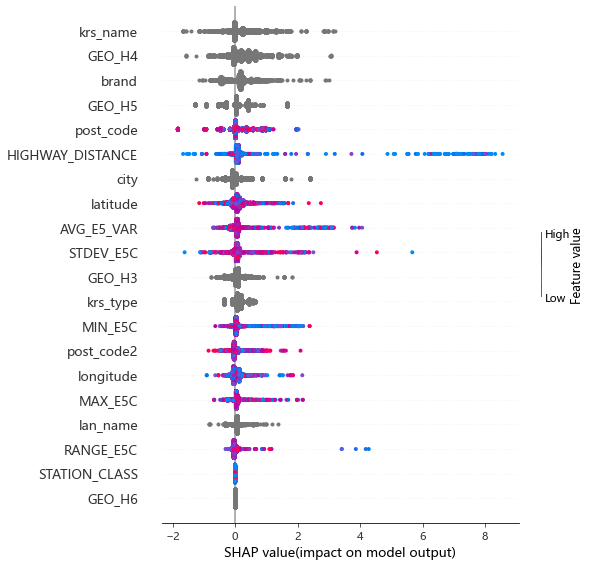

In [66]:
#  Show the distribution of the impacts each feature has on the model output using Shapley ML explainability values 
import pydotplus
import graphviz
from hana_ml.visualizers.model_debriefing import TreeModelDebriefing

shapley_explainer = TreeModelDebriefing.shapley_explainer(pred_res, df_test, key='uuid', label='STATION_CLASS')
shapley_explainer.summary_plot()

In [ ]:
# Show the "local" distribution impact of each feature for individual predictions 
shapley_explainer = TreeModelDebriefing.shapley_explainer(pred_res.head(5), df_test.head(5), 
                                                          key='uuid', label='STATION_CLASS')
shapley_explainer.force_plot()

In [82]:
# Save Models and Model Quality Information to MLLAB-Sandbox
from hana_ml.model_storage import ModelStorage

MLLAB_models = ModelStorage(connection_context=conn)

hgbc.name = 'STATION PRICE-CLASS CLASSIFIER MODEL' 
hgbc.version = 1

MLLAB_models.save_model(model=hgbc)


In [83]:
# Retrieve model from ModelStorage location
from hana_ml.model_storage import ModelStorage
MLLAB_models = ModelStorage(connection_context=conn)

list_models = MLLAB_models.list_models()
display(list_models)

,NAME,VERSION,LIBRARY,CLASS,JSON,TIMESTAMP,STORAGE_TYPE,MODEL_STORAGE_VER,SCHEDULE,MODEL_REPORT
0,STATION PRICE-CLASS CLASSIFIER MODEL,1,PAL,hana_ml.algorithms.pal.unified_classification.UnifiedClassification,"{""model_attributes"": {""func"": ""HybridGradientBoostingTree"", ""multi_class"": null, ""massive"": false, ""group_params"": null, ""kwargs"": {""n_estimators"": 100, ""split_threshold"": 0.1, ""learning_rate"": 0.5, ""fold_num"": 5, ""max_depth"": 5, ""evaluation_metric"": ""error_rate"", ""ref_metric"": [""auc""]}}, ""fit_params"": {""key"": ""uuid"", ""features"": null, ""label"": ""STATION_CLASS"", ""group_key"": null, ""group_params"": null, ""purpose"": null, ""partition_method"": null, ""stratified_column"": null, ""partition_random_state"": null, ""training_percent"": null, ""training_size"": null, ""ntiles"": 20, ""categorical_variable"": null, ""output_partition_result"": null, ""background_size"": null, ""background_random_state"": null, ""build_report"": true, ""impute"": true, ""strategy"": null, ""strategy_by_col"": null, ""als_factors"": null, ""als_lambda"": null, ""als_maxit"": null, ""als_randomstate"": null, ""als_exit_threshold"": null, ""als_exit_interval"": null, ""als_linsolver"": null, ""als_cg_maxit"": null, ""als_centering"": null, ""als_scaling"": null, ""kwargs"": {}}, ""artifacts"": {""schema"": ""TECHED_USER_999"", ""model_tables"": [""HANAML_STATION_PRICE-CLASS_CLASSIFIER_MODEL_1_MODELS_0"", ""HANAML_STATION_PRICE-CLASS_CLASSIFIER_MODEL_1_MODELS_1"", ""HANAML_STATION_PRICE-CLASS_CLASSIFIER_MODEL_1_MODELS_2"", ""HANAML_STATION_PRICE-CLASS_CLASSIFIER_MODEL_1_MODELS_3"", ""HANAML_STATION_PRICE-CLASS_CLASSIFIER_MODEL_1_MODELS_4"", ""HANAML_STATION_PRICE-CLASS_CLASSIFIER_MODEL_1_MODELS_5""], ""library"": ""PAL""}, ""pal_meta"": {""_fit_param"": [[""FUNCTION"", ""HGBT"", ""string""], [""KEY"", 1, ""integer""], [""N_ESTIMATORS"", 100, ""integer""], [""SPLIT_THRESHOLD"", 0.1, ""float""], [""LEARNING_RATE"", 0.5, ""float""], [""FOLD_NUM"", 5, ""integer""], [""MAX_DEPTH"", 5, ""integer""], [""EVALUATION_METRIC"", ""ERROR_RATE"", ""string""], [""REF_METRIC"", ""AUC"", ""string""], [""NTILES"", 20, ""integer""], [""HANDLE_MISSING_VALUE"", 1, ""integer""], [""CATEGORICAL_VARIABLE"", ""STATION_CLASS"", ""string""]], ""_predict_param"": [[""FUNCTION"", ""HGBT"", ""string""], [""HANDLE_MISSING_VALUE"", 1, ""integer""]], ""fit_data_struct"": {""uuid"": ""NVARCHAR(5000)"", ""brand"": ""NVARCHAR(5000)"", ""post_code"": ""NVARCHAR(5000)"", ""post_code2"": ""NVARCHAR(2)"", ""city"": ""NVARCHAR(5000)"", ""longitude"": ""DOUBLE"", ""latitude"": ""DOUBLE"", ""GEO_H3"": ""NVARCHAR(5000)"", ""GEO_H4"": ""NVARCHAR(5000)"", ""GEO_H5"": ""NVARCHAR(5000)"", ""GEO_H6"": ""NVARCHAR(5000)"", ""GEO_H7"": ""NVARCHAR(5000)"", ""lan_name"": ""NVARCHAR(255)"", ""krs_name"": ""NVARCHAR(255)"", ""krs_type"": ""NVARCHAR(255)"", ""HIGHWAY_DISTANCE"": ""DOUBLE"", ""MIN_E5C"": ""DOUBLE"", ""MAX_E5C"": ""DOUBLE"", ""STDEV_E5C"": ""DECIMAL(25, 6)"", ""RANGE_E5C"": ""DOUBLE"", ""AVG_E5_VAR"": ""DOUBLE"", ""STATION_CLASS"": ""INT""}, ""predict_data_struct"": {""uuid"": ""NVARCHAR(5000)"", ""brand"": ""NVARCHAR(5000)"", ""post_code"": ""NVARCHAR(5000)"", ""post_code2"": ""NVARCHAR(2)"", ""city"": ""NVARCHAR(5000)"", ""longitude"": ""DOUBLE"", ""latitude"": ""DOUBLE"", ""GEO_H3"": ""NVARCHAR(5000)"", ""GEO_H4"": ""NVARCHAR(5000)"", ""GEO_H5"": ""NVARCHAR(5000)"", ""GEO_H6"": ""NVARCHAR(5000)"", ""GEO_H7"": ""NVARCHAR(5000)"", ""lan_name"": ""NVARCHAR(255)"", ""krs_name"": ""NVARCHAR(255)"", ""krs_type"": ""NVARCHAR(255)"", ""HIGHWAY_DISTANCE"": ""DOUBLE"", ""MIN_E5C"": ""DOUBLE"", ""MAX_E5C"": ""DOUBLE"", ""STDEV_E5C"": ""DECIMAL(25, 6)"", ""RANGE_E5C"": ""DOUBLE"", ""AVG_E5_VAR"": ""DOUBLE""}, ""label"": ""STATION_CLASS""}}",2022-10-10 10:34:43,default,1,"{""schedule"": {""status"": ""inactive"", ""schedule_time"": ""every 1 hours"", ""pid"": null, ""client"": null, ""connection"": {""userkey"": ""your_userkey"", ""encrypt"": ""false"",

In [85]:
# Reload model from ModelStorage
mymodel = MLLAB_models.load_model('STATION PRICE-CLASS CLASSIFIER MODEL', 1)

# Predict with reloaded model
pred_results=mymodel.predict(data=df_test, key='uuid', features=features, impute=True)

# Build Model Report
from hana_ml.visualizers.unified_report import UnifiedReport
UnifiedReport(mymodel).build().display()



In order to review the unified classification model report better, you need to adjust the size of the left area or hide the left area temporarily!


In [ ]:
# CleanUp Model Storage
MLLAB_models.delete_models(name='STATION PRICE-CLASS CLASSIFIER MODEL')
MLLAB_models.clean_up()

# Reference info - OSMX import german highways

In [ ]:
%%time
import osmnx as ox
# !!careful, downloading the german highway network via OSMNX takes multiple hours
# If you want to try this out, try out the next step instead download the highway network for a single region

# Use OSMNX-method to download network graph from "place"
ox.config(use_cache=True, log_console=True)
cf = '["highway"~"motorway"]'
#g =  ox.graph_from_place('Germany', network_type = 'drive', custom_filter=cf)


In [ ]:
%%time
import osmnx as ox
hdf_RNK_SHAPE = stations_spatial.filter("\"krs_name\"='Landkreis Rhein-Neckar-Kreis'" ).select('uuid','krs_name', 'SHAPE').head(1)
display(hdf_RNK_SHAPE.drop('SHAPE').collect())

# Create Geopandas Dataframe from the HANA dataframe
gdf_RNK_SHAPE = gpd.GeoDataFrame(hdf_RNK_SHAPE.select('uuid', 'SHAPE').collect(), geometry='SHAPE')
gdf_RNK_SHAPE=gdf_RNK_SHAPE.rename_geometry('geometry')
display(gdf_RNK_SHAPE.head(10))

# Use OSMNX-method to download network graph from polygon
ox.config(use_cache=True, log_console=True)
cf = '["highway"~"motorway"]'
g = ox.graph_from_polygon(polygon = gdf_RNK_SHAPE['geometry'][0], network_type = 'drive',custom_filter=cf)
#fig, ax = ox.plot_graph(g, fig_height=5)


In [ ]:
# Check successful object download
g

# Plot OSMNX highway network graph data
fig, ax = ox.plot_graph(g)
#6.2.4-osmx_highway_plot.png

In [ ]:
# Create geodataframes from network graph
gdf_nodes,gdf_edges = ox.graph_to_gdfs(g, nodes=True, edges=True)
gdf_edges
#6.2.5-gdf_edges.png

In [ ]:
# Convert network arrays to str-column format for the pandas dataframe
gdf_edges['ID'] = np.arange(len(gdf_edges))
gdf_edges['osmid']=gdf_edges['osmid'].astype(str)
gdf_edges['ref']=gdf_edges['ref'].astype(str)
gdf_edges['highway']=gdf_edges['highway'].astype(str)

# Create a pandas dataframe, needed for the HANA dataframe import
pd_edges=pd.DataFrame(gdf_edges, copy=True)[['ID', 'osmid', 'geometry', 'highway','ref']]
pd_edges.head(5)
#6.2.6-pd_edges.png

In [ ]:
# Create a HANA dataframe from the German highway-network edges pandas dataframe 
from hana_ml.dataframe import create_dataframe_from_pandas

hdf = create_dataframe_from_pandas(
    connection_context=conn, replace=True,
    pandas_df=pd_edges,
    geo_cols=["geometry"],
    srid=4326,
    schema='TECHED_USER_999',
    table_name="GEO_GERMANY_HIGHWAYS", primary_key='ID'
    , drop_exist_tab=True, force=True)

german_highways = conn.sql('select * from "TECHED_USER_999"."GEO_GERMANY_HIGHWAYS"')
german_highways.head(3).collect()
#6.2.7-german_highway_edges_hdf.png

In [35]:
df=stations_spatial.distinct('krs_name').collect()
krs=list(set(list(df['krs_name'])))
print(sorted(krs))
#6.2.8-german_landkreis_liste.png

['Kreis Borken', 'Kreis Coesfeld', 'Kreis Dithmarschen', 'Kreis Düren', 'Kreis Ennepe-Ruhr-Kreis', 'Kreis Euskirchen', 'Kreis Gütersloh', 'Kreis Heinsberg', 'Kreis Herford', 'Kreis Herzogtum Lauenburg', 'Kreis Hochsauerlandkreis', 'Kreis Höxter', 'Kreis Kleve', 'Kreis Lippe', 'Kreis Mettmann', 'Kreis Minden-Lübbecke', 'Kreis Märkischer Kreis', 'Kreis Nordfriesland', 'Kreis Oberbergischer Kreis', 'Kreis Olpe', 'Kreis Ostholstein', 'Kreis Paderborn', 'Kreis Pinneberg', 'Kreis Plön', 'Kreis Recklinghausen', 'Kreis Rendsburg-Eckernförde', 'Kreis Rhein-Erft-Kreis', 'Kreis Rhein-Kreis Neuss', 'Kreis Rhein-Sieg-Kreis', 'Kreis Rheinisch-Bergischer Kreis', 'Kreis Schleswig-Flensburg', 'Kreis Segeberg', 'Kreis Siegen-Wittgenstein', 'Kreis Soest', 'Kreis Steinburg', 'Kreis Steinfurt', 'Kreis Stormarn', 'Kreis Städteregion Aachen', 'Kreis Unna', 'Kreis Viersen', 'Kreis Warendorf', 'Kreis Wesel', 'Kreisfreie Stadt Amberg', 'Kreisfreie Stadt Ansbach', 'Kreisfreie Stadt Aschaffenburg', 'Kreisfreie St

In [ ]:
#SQL

#Calculate single Highway-Multilinestring from Highway network into temporary table #HWL
CREATE LOCAL TEMPORARY COLUMN TABLE #HWL ( HIGHWAY NVARCHAR(24), HIGHWAY_LINE ST_GEOMETRY(4326));
--#ALTER TABLE HWAY ALTER (HIGHWAY_LINE ST_GEOMETRY(4326));
INSERT INTO #HWL
	SELECT "highway",  NEW ST_MultiLineString('MultiLineString (' || substring(LSTRING,3) || ')', 4326) AS HIGHWAY_LINE
				FROM (
						SELECT "highway", replace(agg , 'SRID=4326;LINESTRING ', ', ') AS LSTRING
						FROM (
								SELECT "highway",  STRING_AGG("geometry_GEO") AS agg 
								FROM RAW_DATA.GEO_GERMANY_HIGHWAYS 
								WHERE substr("ref",1,1)='A' AND "highway"='motorway'
								GROUP BY "highway"
							)
					);
        
CREATE COLUMN TABLE STATION_HWAYDIST ("uuid" NVARCHAR(5000), HIGHWAY_DISTANCE DOUBLE);
INSERT INTO STATION_HWAYDIST 
SELECT "uuid", "STATION_P".ST_SRID(1000004326).ST_DISTANCE(HIGHWAY_LINE.ST_SRID(1000004326), 'meter') AS HIGHWAY_DISTANCE
from
	(SELECT "uuid", "longitude_latitude_GEO".ST_SRID(4326) AS "STATION_P" 
   		FROM 	(SELECT S."uuid", "longitude_latitude_GEO"
         		from TECHED_USER_999.STATION_PRICECLASSIFICATION S, TECHED_USER_999.GAS_STATIONS G
         		WHERE S."krs_name" in (
 'Kreis Borken', 'Kreis Coesfeld', 'Kreis Dithmarschen', 'Kreis Düren', 'Kreis Ennepe-Ruhr-Kreis', 'Kreis Euskirchen', 
 'Kreis Gütersloh', 'Kreis Heinsberg', 'Kreis Herford', 'Kreis Herzogtum Lauenburg', 'Kreis Hochsauerlandkreis', 
  ...
  'Landkreis Würzburg', 'Landkreis Zollernalbkreis', 'Landkreis Zwickau', 'Stadtkreis Baden-Baden', 
  'Stadtkreis Freiburg im Breisgau', 'Stadtkreis Heidelberg', 'Stadtkreis Heilbronn', 'Stadtkreis Karlsruhe', 
  'Stadtkreis Mannheim', 'Stadtkreis Pforzheim', 'Stadtkreis Stuttgart', 'Stadtkreis Ulm'
         		) AND
         		       S."uuid"=G."uuid"
         		) AS P
     ),
     #HWL;

In [ ]:
stations_hwaydist=conn.table("STATION_HWAYDIST")
display(stations_hwaydist.head(5).collect())
#6.2.9-german_highwaydist.png